1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import pandas as pd # standard naming convention
import numpy as np
import random

file_name = "./data/data_000637.txt"

df = pd.read_csv(file_name, nrows=random.randint(10000,1310720))

df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1197226,1,1,20,3869210418,1478,27
1197227,1,0,116,3869210418,1479,4
1197228,1,1,50,3869210418,1484,14
1197229,1,0,32,3869210418,1487,28


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [2]:
maxClm = df['BX_COUNTER'].max() 
print(maxClm) 

3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [3]:
df['ABS_TIME'] = df['ORBIT_CNT']*maxClm*25+ df['BX_COUNTER']*25 + df['TDC_MEAS']*25/30
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
...,...,...,...,...,...,...,...
1197226,1,1,20,3869210418,1478,27,3.446499e+14
1197227,1,0,116,3869210418,1479,4,3.446499e+14
1197228,1,1,50,3869210418,1484,14,3.446499e+14
1197229,1,0,32,3869210418,1487,28,3.446499e+14


In [4]:
df['ABS_TIME'] = pd.to_datetime(df['ABS_TIME'], unit='ns')
df['ABS_TIME']

0         1970-01-04 23:44:09.004934896
1         1970-01-04 23:44:09.004934897
2         1970-01-04 23:44:09.004939373
3         1970-01-04 23:44:09.004939490
4         1970-01-04 23:44:09.004944545
                       ...             
1197226   1970-01-04 23:44:09.918020322
1197227   1970-01-04 23:44:09.918020328
1197228   1970-01-04 23:44:09.918020461
1197229   1970-01-04 23:44:09.918020548
1197230   1970-01-04 23:44:09.918020357
Name: ABS_TIME, Length: 1197231, dtype: datetime64[ns]

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
df['ABS_TIME'].max() - df['ABS_TIME'].min()

Timedelta('0 days 00:00:00.913085652')

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
noisyCh = df.groupby('BX_COUNTER').count()['FPGA'].nlargest(3)
noisyCh

BX_COUNTER
3437    425
3008    420
756     418
Name: FPGA, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
nonEmpty = df[df['TDC_MEAS'] >= 1]['ORBIT_CNT']
len(nonEmpty)

1062332

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
uniqueOrbits = np.unique(df[df['TDC_CHANNEL'] == 139]['ORBIT_CNT'])
print(len(uniqueOrbits))

10223


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [9]:
df0 = df.loc[df['FPGA'] == 0]
df1 = df.loc[df['FPGA'] == 1]

s0 = pd.Series(df0['TDC_MEAS'], index=df0['TDC_CHANNEL'])
s1 = pd.Series(df['TDC_MEAS'], index=df['TDC_CHANNEL'])

s0, s1

(TDC_CHANNEL
 123     NaN
 124     9.0
 63      NaN
 64     12.0
 64     12.0
        ... 
 23     15.0
 64     12.0
 116     NaN
 32     25.0
 58      NaN
 Name: TDC_MEAS, Length: 842688, dtype: float64,
 TDC_CHANNEL
 123    17
 124     9
 63     17
 64     12
 64     12
        ..
 20     14
 116     0
 50      9
 32     25
 58      6
 Name: TDC_MEAS, Length: 1197231, dtype: int64)

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0, 0.5, 'Counts')

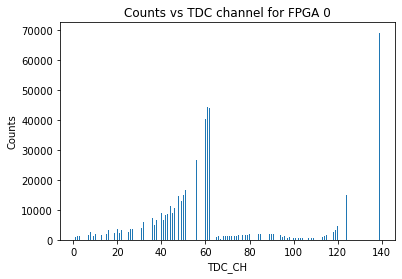

In [10]:
import matplotlib.pyplot as plt

TDC0 = df0['TDC_CHANNEL']
plt.figure()
plt.hist(TDC0, bins='auto')
plt.title('Counts vs TDC channel for FPGA 0')
plt.xlabel('TDC_CH')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

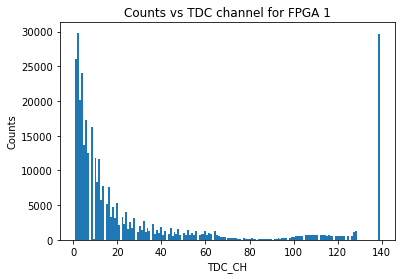

In [11]:
TDC1 = df1['TDC_CHANNEL']
plt.figure()
plt.hist(TDC1, bins='auto')
plt.title('Counts vs TDC channel for FPGA 1')
plt.xlabel('TDC_CH')
plt.ylabel('Counts')